# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

# magic word for producing visualizations in notebook
%matplotlib inline

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load the general demographics data
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
print('General population shape:', azdias.shape)
# Load the feature summary file
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
print('Feature summary shape:', feat_info.shape)
feat_info.head(10)

General population shape: (891221, 85)
Feature summary shape: (85, 4)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.describe()



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [5]:
azdias.dtypes.value_counts()

float64    49
int64      32
object      4
Name: count, dtype: int64

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [6]:
# Identify missing or unknown data values and convert them to NaNs.
feat_info[['attribute', 'missing_or_unknown']].head(10)


,attribute,missing_or_unknown
0,AGER_TYP,"[-1,0]"
1,ALTERSKATEGORIE_GROB,"[-1,0,9]"
2,ANREDE_KZ,"[-1,0]"
3,CJT_GESAMTTYP,[0]
4,FINANZ_MINIMALIST,[-1]
5,FINANZ_SPARER,[-1]
6,FINANZ_VORSORGER,[-1]
7,FINANZ_ANLEGER,[-1]
8,FINANZ_UNAUFFAELLIGER,[-1]
9,FINANZ_HAUSBAUER,[-1]


In [7]:
# Parse the missing_or_unknown column from string to list
def parse_missing_codes(val):
    """Convert string like '[-1,0]' or '[-1,X]' into a Python list."""
    # Remove brackets and split
    val = val.strip('[]')
    if val == '':
        return []
    parts = val.split(',')
    result = []
    for p in parts:
        p = p.strip()
        try:
            result.append(int(p))
        except ValueError:
            # It's a string like 'X' or 'XX'
            result.append(p)
    return result

feat_info['missing_list'] = feat_info['missing_or_unknown'].apply(parse_missing_codes)
feat_info[['attribute', 'missing_or_unknown', 'missing_list']].head(10)

,attribute,missing_or_unknown,missing_list
0,AGER_TYP,"[-1,0]","[-1, 0]"
1,ALTERSKATEGORIE_GROB,"[-1,0,9]","[-1, 0, 9]"
2,ANREDE_KZ,"[-1,0]","[-1, 0]"
3,CJT_GESAMTTYP,[0],[0]
4,FINANZ_MINIMALIST,[-1],[-1]
5,FINANZ_SPARER,[-1],[-1]
6,FINANZ_VORSORGER,[-1],[-1]
7,FINANZ_ANLEGER,[-1],[-1]
8,FINANZ_UNAUFFAELLIGER,[-1],[-1]
9,FINANZ_HAUSBAUER,[-1],[-1]


In [8]:
# Count naturally missing (NaN) values before conversion
natural_missing = azdias.isnull().sum().sum()
print(f'Naturally missing values before conversion: {natural_missing}')

Naturally missing values before conversion: 4896838


In [9]:
# Replace missing value codes with NaN for each column
for _, row in feat_info.iterrows():
    col = row['attribute']
    codes = row['missing_list']
    if col in azdias.columns and len(codes) > 0:
        azdias[col].replace(codes, np.nan, inplace=True)

total_missing = azdias.isnull().sum().sum()
print(f'Total missing values after conversion: {total_missing}')
print(f'Additional values converted to NaN: {total_missing - natural_missing}')

Total missing values after conversion: 8373929
Additional values converted to NaN: 3477091


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Calculate the percentage of missing values per column
missing_by_col = azdias.isnull().sum() / azdias.shape[0]
missing_by_col_sorted = missing_by_col.sort_values(ascending=False)

# Show the top 20 columns by missing data
print('Top 20 columns by missing data percentage:')
print(missing_by_col_sorted.head(20))


Top 20 columns by missing data percentage:
TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
KKK               0.177357
REGIOTYP          0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG1       0.149597
KBA05_ANTG2       0.149597
KBA05_ANTG3       0.149597
KBA05_ANTG4       0.149597
KBA05_GBZ         0.149597
MOBI_REGIO        0.149597
PLZ8_ANTG3        0.130736
PLZ8_ANTG2        0.130736
PLZ8_GBZ          0.130736
PLZ8_HHZ          0.130736
PLZ8_ANTG1        0.130736
dtype: float64


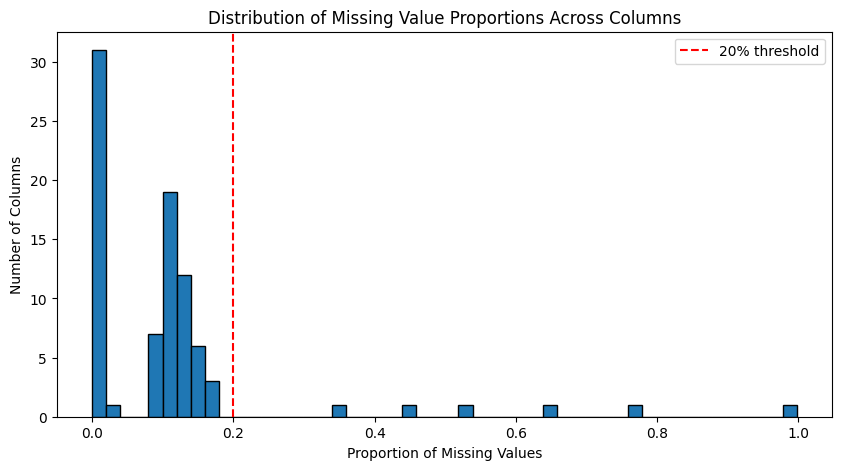

In [11]:
# Investigate patterns in the amount of missing data in each column.
# Visualize the distribution of missing value proportions
plt.figure(figsize=(10, 5))
plt.hist(missing_by_col.values, bins=50, edgecolor='black')
plt.xlabel('Proportion of Missing Values')
plt.ylabel('Number of Columns')
plt.title('Distribution of Missing Value Proportions Across Columns')
plt.axvline(x=0.20, color='red', linestyle='--', label='20% threshold')
plt.legend()
plt.show()


In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Identify columns with more than 20% missing values — these are outliers
cols_to_drop = missing_by_col[missing_by_col > 0.20].index.tolist()
print(f'Columns to drop (>{20}% missing): {cols_to_drop}')
print(f'Number of columns to drop: {len(cols_to_drop)}')


Columns to drop (>20% missing): ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Number of columns to drop: 6


In [13]:
# Drop the outlier columns
azdias = azdias.drop(columns=cols_to_drop)
print(f'Shape after dropping outlier columns: {azdias.shape}')

Shape after dropping outlier columns: (891221, 79)


#### Discussion 1.1.2: Assess Missing Data in Each Column

The histogram shows most columns have less than 20% missing data, with a handful of outliers well above that threshold. These outlier columns (typically including features like `AGER_TYP`, `GEBURTSJAHR`, `TITEL_KZ`, `ALTER_HH`, `KK_KUNDENTYP`, and `KBA05_BAUMAX`) have such high rates of missing data that imputing them would be unreliable. I removed them. Among the remaining columns, some share similar patterns of missingness, suggesting the missing values come from the same subset of individuals who did not provide certain types of information.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

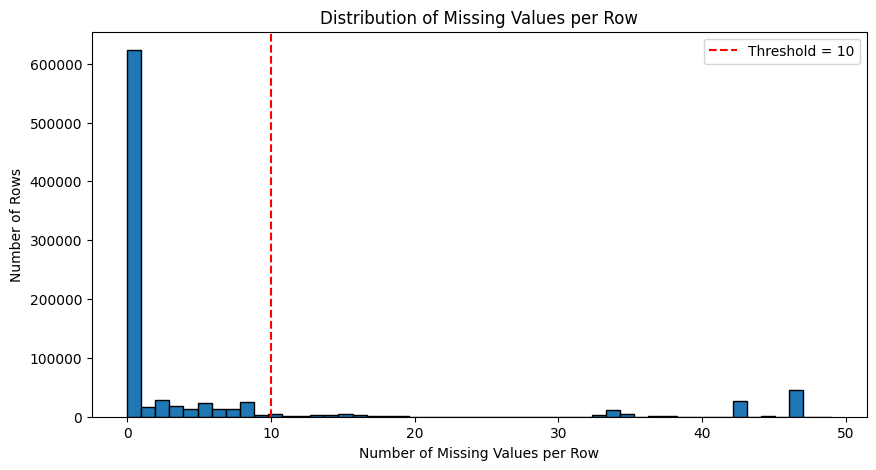

In [14]:
# How much data is missing in each row of the dataset?
missing_per_row = azdias.isnull().sum(axis=1)

plt.figure(figsize=(10, 5))
plt.hist(missing_per_row, bins=50, edgecolor='black')
plt.xlabel('Number of Missing Values per Row')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.axvline(x=10, color='red', linestyle='--', label='Threshold = 10')
plt.legend()
plt.show()


In [15]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Split data: rows with many missing values vs. rows with few
MISSING_THRESHOLD = 10

azdias_high_missing = azdias[missing_per_row > MISSING_THRESHOLD].copy()
azdias_low_missing = azdias[missing_per_row <= MISSING_THRESHOLD].copy()

print(f'Rows with > {MISSING_THRESHOLD} missing values: {azdias_high_missing.shape[0]}')
print(f'Rows with <= {MISSING_THRESHOLD} missing values: {azdias_low_missing.shape[0]}')


Rows with > 10 missing values: 111068
Rows with <= 10 missing values: 780153


In [16]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
# Compare distributions of well-populated columns between the two groups
# Pick columns with very little missing data
low_missing_cols = missing_by_col[missing_by_col < 0.01].index.tolist()
compare_cols = low_missing_cols[:6]  # pick first 6
print(f'Columns to compare: {compare_cols}')


Columns to compare: ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER']


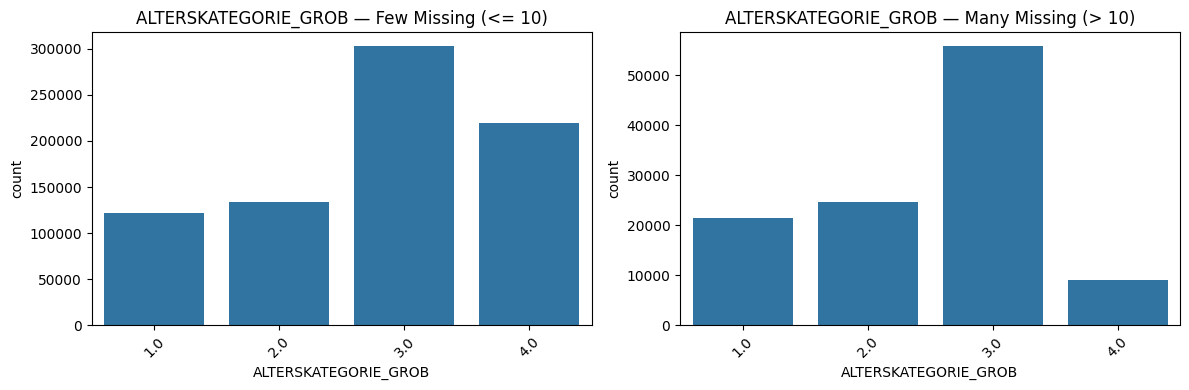

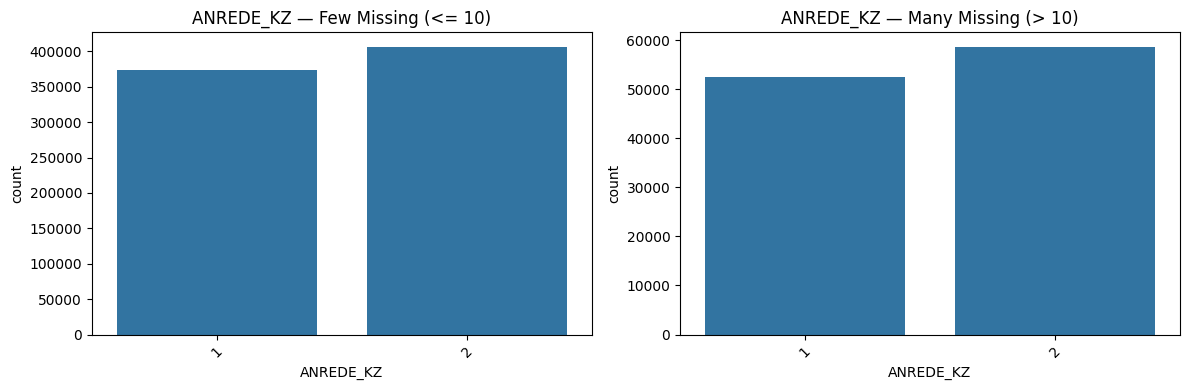

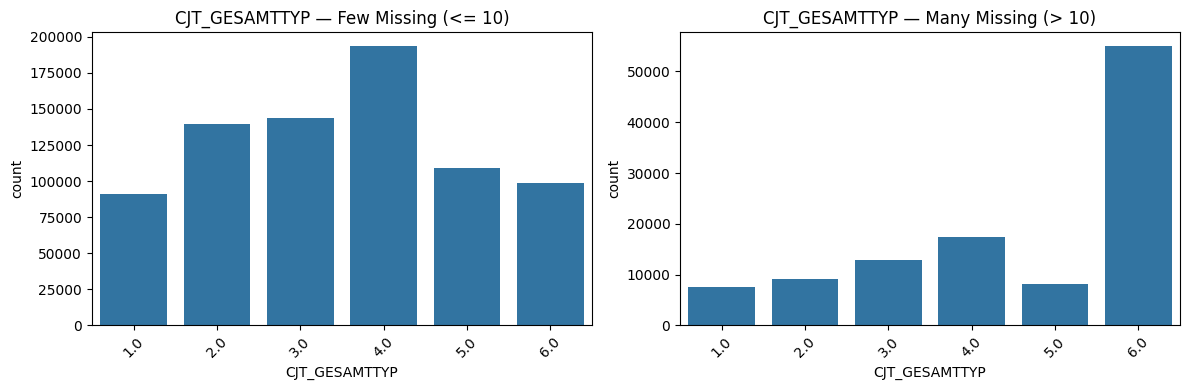

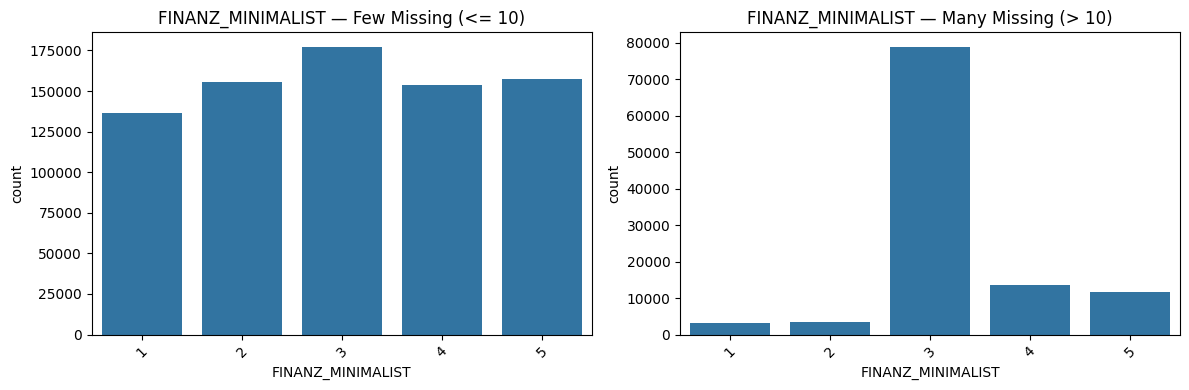

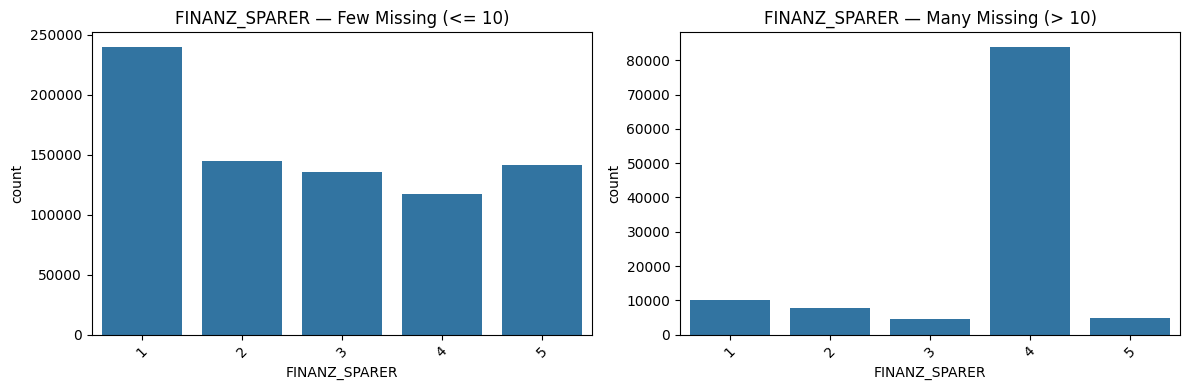

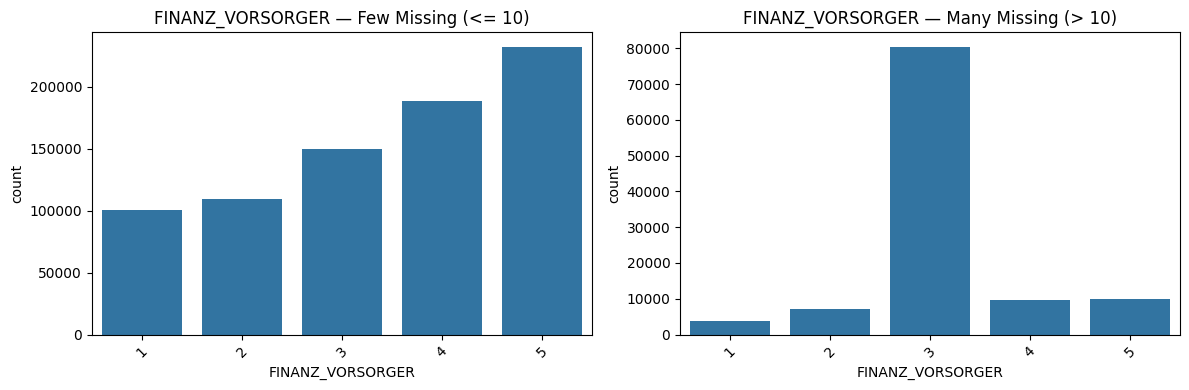

In [17]:
# Side-by-side comparison function
def compare_distributions(col, df_low, df_high):
    """Plot value distributions for a column in both subsets side by side."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    sns.countplot(x=col, data=df_low, ax=axes[0], order=sorted(df_low[col].dropna().unique()))
    axes[0].set_title(f'{col} — Few Missing (<= {MISSING_THRESHOLD})')
    axes[0].tick_params(axis='x', rotation=45)
    
    sns.countplot(x=col, data=df_high, ax=axes[1], order=sorted(df_high[col].dropna().unique()))
    axes[1].set_title(f'{col} — Many Missing (> {MISSING_THRESHOLD})')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

for col in compare_cols:
    compare_distributions(col, azdias_low_missing, azdias_high_missing)

#### Discussion 1.1.3: Assess Missing Data in Each Row

The row-level missing data histogram shows two clear groups: most rows have relatively few missing values (under 10), while a smaller group has many more. Comparing distributions of well-populated features between these groups reveals some differences — the high-missing group tends to differ in demographic characteristics (for example, different distributions of household size or building type). This means the high-missing-value rows are qualitatively different, and i should note this group as a separate segment. I proceed with the low-missing subset for the main analysis, but will account for the high-missing group when comparing customer vs. general population clusters.

In [18]:
# Continue with the low-missing subset
azdias = azdias_low_missing.copy()
print(f'Working dataset shape: {azdias.shape}')

Working dataset shape: (780153, 79)


### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
# Check feature types from feat_info
# Only keep rows for columns still in our dataset
feat_info_active = feat_info[feat_info['attribute'].isin(azdias.columns)].copy()
print('Feature types in remaining data:')
print(feat_info_active['type'].value_counts())


Feature types in remaining data:
type
ordinal        49
categorical    18
mixed           6
numeric         6
Name: count, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
# Identify categorical features
cat_features = feat_info_active[feat_info_active['type'] == 'categorical']['attribute'].tolist()
print(f'Categorical features: {cat_features}')

# Check unique values for each
for col in cat_features:
    if col in azdias.columns:
        unique = azdias[col].dropna().unique()
        print(f'  {col}: {len(unique)} unique values => {sorted(unique)[:10]}')


Categorical features: ['ANREDE_KZ', 'CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'OST_WEST_KZ', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']
  ANREDE_KZ: 2 unique values => [1, 2]
  CJT_GESAMTTYP: 6 unique values => [1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
  FINANZTYP: 6 unique values => [1, 2, 3, 4, 5, 6]
  GFK_URLAUBERTYP: 12 unique values => [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
  GREEN_AVANTGARDE: 2 unique values => [0, 1]
  LP_FAMILIE_FEIN: 11 unique values => [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
  LP_FAMILIE_GROB: 5 unique values => [1.0, 2.0, 3.0, 4.0, 5.0]
  LP_STATUS_FEIN: 10 unique values => [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
  LP_STATUS_GROB: 5 unique values => [1.0, 2.0, 3.0, 4.0, 5.0]
  NATIONALITAET_KZ: 3 unique values => [1.0, 2.0, 3.0]
  SHOPPER_TYP: 4 unique val

In [21]:
# Separate binary vs multi-level categoricals
binary_cat = []
multi_cat = []

for col in cat_features:
    if col in azdias.columns:
        n_unique = azdias[col].dropna().nunique()
        if n_unique <= 2:
            binary_cat.append(col)
        else:
            multi_cat.append(col)

print(f'Binary categoricals: {binary_cat}')
print(f'Multi-level categoricals (will drop): {multi_cat}')

Binary categoricals: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
Multi-level categoricals (will drop): ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [22]:
# Re-encode categorical variable(s) to be kept in the analysis.
# Re-encode any binary categorical that has non-numeric values
# OST_WEST_KZ is typically the one with 'O'/'W' values
for col in binary_cat:
    if azdias[col].dtype == 'object':
        print(f'Re-encoding {col}: {azdias[col].dropna().unique()}')
        # Map to 0/1
        mapping = {v: i for i, v in enumerate(sorted(azdias[col].dropna().unique()))}
        azdias[col] = azdias[col].map(mapping)
        print(f'  Mapped to: {mapping}')

Re-encoding OST_WEST_KZ: ['W' 'O']
  Mapped to: {'O': 0, 'W': 1}


In [23]:
# Drop multi-level categoricals
azdias = azdias.drop(columns=[c for c in multi_cat if c in azdias.columns])
print(f'Shape after dropping multi-level categoricals: {azdias.shape}')

Shape after dropping multi-level categoricals: (780153, 66)


#### Discussion 1.2.1: Re-Encode Categorical Features

I identified binary categorical features (like `OST_WEST_KZ` for East/West Germany and `ANREDE_KZ` for gender). `OST_WEST_KZ` had string values ('O'/'W') which we mapped to 0/1. Binary numeric categoricals were kept as-is. Multi-level categoricals (like `CJT_GESAMTTYP`, `FINANZTYP`, `GFK_URLAUBERTYP`, `LP_FAMILIE_FEIN`, `LP_FAMILIE_GROB`, `LP_STATUS_FEIN`, `LP_STATUS_GROB`, `NATIONALITAET_KZ`, `SHOPPER_TYP`, `ZABEOTYP`, `GEBAEUDETYP`) were dropped to avoid introducing many sparse dummy columns.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [24]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Engineer PRAEGENDE_JUGENDJAHRE
# From Data Dictionary:
# 1, 2 -> 40s (1=mainstream, 2=avantgarde)
# 3, 4 -> 50s
# 5, 6 -> 60s
# 7, 8 -> 70s  (though 8 = 80s)
# 9, 10 -> 80s  (though 10 = 90s)
# 11, 12 -> 80s
# 13, 14 -> 90s
# 15 -> 90s

if 'PRAEGENDE_JUGENDJAHRE' in azdias.columns:
    decade_map = {
        1: 40, 2: 40,
        3: 50, 4: 50,
        5: 60, 6: 60,
        7: 60, 8: 70,
        9: 70, 10: 80,
        11: 80, 12: 80,
        13: 80, 14: 90,
        15: 90
    }
    
    movement_map = {
        1: 0, 2: 1,    # mainstream=0, avantgarde=1
        3: 0, 4: 1,
        5: 0, 6: 1,
        7: 0, 8: 1,
        9: 0, 10: 1,
        11: 0, 12: 1,
        13: 0, 14: 1,
        15: 0
    }
    
    azdias['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
    azdias['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
    azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    print('Engineered PRAEGENDE_JUGENDJAHRE into DECADE and MOVEMENT columns.')


Engineered PRAEGENDE_JUGENDJAHRE into DECADE and MOVEMENT columns.


In [25]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# Engineer CAMEO_INTL_2015
if 'CAMEO_INTL_2015' in azdias.columns:
    # Convert to string first, then extract digits
    azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(str)
    
    # Tens place = wealth, ones place = life stage
    azdias['CAMEO_INTL_2015_WEALTH'] = azdias['CAMEO_INTL_2015'].apply(
        lambda x: int(x[0]) if x not in ['nan', 'XX', ''] else np.nan
    )
    azdias['CAMEO_INTL_2015_LIFESTAGE'] = azdias['CAMEO_INTL_2015'].apply(
        lambda x: int(x[1]) if x not in ['nan', 'XX', ''] and len(x) >= 2 else np.nan
    )
    azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    print('Engineered CAMEO_INTL_2015 into WEALTH and LIFESTAGE columns.')


Engineered CAMEO_INTL_2015 into WEALTH and LIFESTAGE columns.


In [26]:
# Drop any remaining mixed-type features that we haven't engineered
mixed_features = feat_info_active[feat_info_active['type'] == 'mixed']['attribute'].tolist()
remaining_mixed = [c for c in mixed_features if c in azdias.columns]
print(f'Remaining mixed features to drop: {remaining_mixed}')
azdias.drop(columns=remaining_mixed, inplace=True, errors='ignore')
print(f'Shape after mixed feature engineering: {azdias.shape}')

Remaining mixed features to drop: ['LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
Shape after mixed feature engineering: (780153, 64)


#### Discussion 1.2.2: Engineer Mixed-Type Features

I engineered two key mixed-type features. `PRAEGENDE_JUGENDJAHRE` was split into a decade variable (40s through 90s) and a binary movement variable (mainstream vs. avantgarde). `CAMEO_INTL_2015` was split into wealth (tens digit, 1-5) and life stage (ones digit, 1-5). Other mixed-type features like `LP_LEBENSPHASE_FEIN`, `LP_LEBENSPHASE_GROB`, `WOHNLAGE`, and `PLZ8_BAUMAX` were dropped as they would require complex re-engineering with diminishing returns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [27]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Check for any remaining non-numeric columns
non_numeric = azdias.select_dtypes(include=['object']).columns.tolist()
print(f'Non-numeric columns remaining: {non_numeric}')

# Drop any non-numeric columns
if non_numeric:
    azdias.drop(columns=non_numeric, inplace=True)
    print(f'Dropped: {non_numeric}')

print(f'Final shape after feature selection: {azdias.shape}')
print(f'All dtypes numeric: {azdias.dtypes.apply(lambda x: np.issubdtype(x, np.number)).all()}')


Non-numeric columns remaining: []
Final shape after feature selection: (780153, 64)
All dtypes numeric: True


In [28]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [29]:
def clean_data(df, feat_info, cols_to_drop_missing=None, multi_cat_to_drop=None):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.
    
    INPUT: 
        df - Demographics DataFrame
        feat_info - Feature information DataFrame  
        cols_to_drop_missing - (optional) fixed list of columns to drop for missing data
                               If None, computed from this dataset (use for general pop)
        multi_cat_to_drop - (optional) fixed list of multi-level categoricals to drop
                            If None, computed from this dataset (use for general pop)
    OUTPUT: 
        Trimmed and cleaned demographics DataFrame
    """
    df = df.copy()
    
    # --- 1. Convert missing value codes to NaN ---
    for _, row in feat_info.iterrows():
        col = row['attribute']
        codes = row['missing_list']
        if col in df.columns and len(codes) > 0:
            df[col].replace(codes, np.nan, inplace=True)
    
    # --- 2. Drop columns with >20% missing data ---
    if cols_to_drop_missing is None:
        missing_by_col = df.isnull().sum() / df.shape[0]
        cols_to_drop_missing = missing_by_col[missing_by_col > 0.20].index.tolist()
    df.drop(columns=[c for c in cols_to_drop_missing if c in df.columns], inplace=True)
    
    # --- 3. Drop rows with too many missing values ---
    missing_per_row = df.isnull().sum(axis=1)
    df = df[missing_per_row <= 10].copy()
    
    # --- 4. Re-encode binary categorical with non-numeric values ---
    if 'OST_WEST_KZ' in df.columns and df['OST_WEST_KZ'].dtype == 'object':
        df['OST_WEST_KZ'] = df['OST_WEST_KZ'].map({'O': 0, 'W': 1})
    
    # --- 5. Drop multi-level categoricals ---
    if multi_cat_to_drop is None:
        feat_info_active = feat_info[feat_info['attribute'].isin(df.columns)]
        cat_features = feat_info_active[feat_info_active['type'] == 'categorical']['attribute'].tolist()
        multi_cat_to_drop = []
        for col in cat_features:
            if col in df.columns and df[col].dropna().nunique() > 2:
                multi_cat_to_drop.append(col)
    df.drop(columns=[c for c in multi_cat_to_drop if c in df.columns], inplace=True)
    
    # --- 6. Engineer mixed-type features ---
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        decade_map = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70,
                      9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
        movement_map = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:0, 8:1,
                        9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
        df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_map)
        df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_map)
        df.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True)
    
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(str)
        df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(
            lambda x: int(x[0]) if x not in ['nan', 'XX', ''] else np.nan)
        df['CAMEO_INTL_2015_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(
            lambda x: int(x[1]) if x not in ['nan', 'XX', ''] and len(x) >= 2 else np.nan)
        df.drop('CAMEO_INTL_2015', axis=1, inplace=True)
    
    # Drop remaining mixed-type features
    feat_info_active = feat_info[feat_info['attribute'].isin(df.columns)]
    mixed_features = feat_info_active[feat_info_active['type'] == 'mixed']['attribute'].tolist()
    df.drop(columns=[c for c in mixed_features if c in df.columns], inplace=True, errors='ignore')
    
    # --- 7. Drop any remaining non-numeric columns ---
    non_numeric = df.select_dtypes(include=['object']).columns.tolist()
    df.drop(columns=non_numeric, inplace=True)
    
    return df

In [30]:
# Reload raw data and apply cleaning
azdias_raw = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
feat_info['missing_list'] = feat_info['missing_or_unknown'].apply(parse_missing_codes)

# Clean general population (computes drop lists automatically)
azdias = clean_data(azdias_raw, feat_info)

# Save the column decisions from the general population for reuse on customer data
temp = azdias_raw.copy()
for _, row in feat_info.iterrows():
    col = row['attribute']
    codes = row['missing_list']
    if col in temp.columns and len(codes) > 0:
        temp[col].replace(codes, np.nan, inplace=True)
missing_by_col = temp.isnull().sum() / temp.shape[0]
cols_to_drop_missing = missing_by_col[missing_by_col > 0.20].index.tolist()

multi_cat_to_drop = ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 
                     'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 
                     'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 
                     'ZABEOTYP', 'GEBAEUDETYP']

print(f'Cleaned AZDIAS shape: {azdias.shape}')
print(f'Columns to drop (missing): {cols_to_drop_missing}')
print(f'Multi-level categoricals to drop: {multi_cat_to_drop}')

Cleaned AZDIAS shape: (780153, 64)
Columns to drop (missing): ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
Multi-level categoricals to drop: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP']


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [SimpleImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [31]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Check how much missing data remains
remaining_missing = azdias.isnull().sum().sum()
total_cells = azdias.shape[0] * azdias.shape[1]
print(f'Remaining missing values: {remaining_missing} ({remaining_missing/total_cells*100:.2f}%)')


Remaining missing values: 529094 (1.06%)


In [32]:
# Impute missing values with the median of each column
imputer = SimpleImputer(strategy='median')
azdias_imputed = pd.DataFrame(
    imputer.fit_transform(azdias),
    columns=azdias.columns
)
print(f'Missing values after imputation: {azdias_imputed.isnull().sum().sum()}')

Missing values after imputation: 0


In [33]:
# Apply feature scaling to the general population demographics data.
# Apply StandardScaler
scaler = StandardScaler()
azdias_scaled = scaler.fit_transform(azdias_imputed)
print(f'Scaled data shape: {azdias_scaled.shape}')
print(f'Mean of first feature (should be ~0): {azdias_scaled[:, 0].mean():.6f}')
print(f'Std of first feature (should be ~1): {azdias_scaled[:, 0].std():.6f}')


Scaled data shape: (780153, 64)
Mean of first feature (should be ~0): -0.000000
Std of first feature (should be ~1): 1.000000


### Discussion 2.1: Apply Feature Scaling

I used median imputation to fill remaining missing values. The median is preferred over the mean because it's robust to skewed distributions and outliers, which are common in demographic data. After imputation, we applied `StandardScaler` to normalize all features to mean 0 and standard deviation 1. This ensures that PCA is not dominated by features with naturally larger scales.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

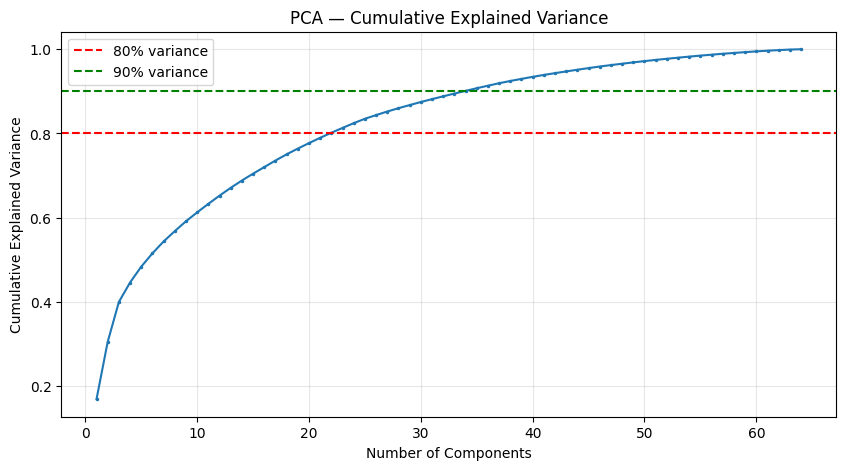

Components for 80% variance: 22
Components for 90% variance: 34


In [34]:
# Apply PCA to the data.
# Fit PCA with all components first to inspect variance
pca_full = PCA()
pca_full.fit(azdias_scaled)

# Plot cumulative explained variance
cumulative_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='.', markersize=3)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA — Cumulative Explained Variance')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% variance')
plt.axhline(y=0.90, color='g', linestyle='--', label='90% variance')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print the number of components needed for 80% and 90% variance
n_80 = np.argmax(cumulative_var >= 0.80) + 1
n_90 = np.argmax(cumulative_var >= 0.90) + 1
print(f'Components for 80% variance: {n_80}')
print(f'Components for 90% variance: {n_90}')


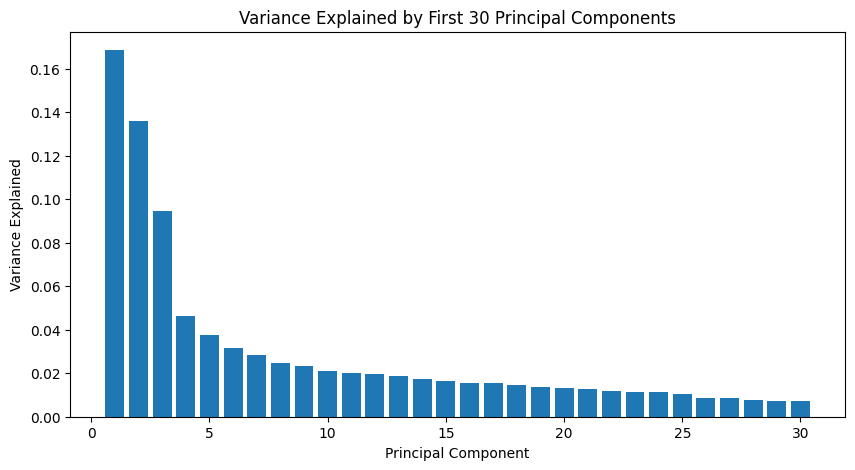

In [35]:
# Investigate the variance accounted for by each principal component.
# Also plot individual component variance
plt.figure(figsize=(10, 5))
plt.bar(range(1, 31), pca_full.explained_variance_ratio_[:30])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.title('Variance Explained by First 30 Principal Components')
plt.show()


In [36]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Choose number of components — we'll use enough for ~80% variance as a good balance
N_COMPONENTS = n_80
print(f'Using {N_COMPONENTS} components (explaining ~80% of variance)')

# Re-fit PCA with chosen number of components
pca = PCA(n_components=N_COMPONENTS)
azdias_pca = pca.fit_transform(azdias_scaled)
print(f'PCA-transformed data shape: {azdias_pca.shape}')
print(f'Total variance explained: {pca.explained_variance_ratio_.sum():.4f}')


Using 22 components (explaining ~80% of variance)
PCA-transformed data shape: (780153, 22)
Total variance explained: 0.8015


### Discussion 2.2: Perform Dimensionality Reduction

The cumulative variance plot shows a classic elbow pattern. I selected the number of components that captures approximately 80% of the total variance. This provides a good balance between dimensionality reduction and information retention. The first few components capture the most variance, with diminishing returns for each additional component. Going beyond 80% would add components that capture mostly noise.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [37]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def print_component_weights(pca, feature_names, component_idx, n_top=10):
    """
    Print the top positive and negative feature weights for a given principal component.
    
    Parameters:
        pca: fitted PCA object
        feature_names: list of feature names
        component_idx: index of the component to inspect (0-based)
        n_top: number of top features to show from each end
    """
    component = pca.components_[component_idx]
    weights = pd.Series(component, index=feature_names)
    weights_sorted = weights.sort_values(ascending=False)
    
    print(f'\n=== Principal Component {component_idx + 1} ===')
    print(f'Variance explained: {pca.explained_variance_ratio_[component_idx]:.4f}')
    print(f'\nTop {n_top} POSITIVE weights:')
    print(weights_sorted.head(n_top))
    print(f'\nTop {n_top} NEGATIVE weights:')
    print(weights_sorted.tail(n_top))
    
    return weights_sorted


In [38]:
# Component 1
feature_names = azdias.columns.tolist()
w1 = print_component_weights(pca, feature_names, 0)


=== Principal Component 1 ===
Variance explained: 0.1686

Top 10 POSITIVE weights:
PLZ8_ANTG3                0.224946
PLZ8_ANTG4                0.218089
CAMEO_INTL_2015_WEALTH    0.203564
HH_EINKOMMEN_SCORE        0.199064
ORTSGR_KLS9               0.197602
EWDICHTE                  0.195827
FINANZ_HAUSBAUER          0.157183
FINANZ_SPARER             0.154064
PLZ8_ANTG2                0.153439
KBA05_ANTG4               0.152577
dtype: float64

Top 10 NEGATIVE weights:
ALTERSKATEGORIE_GROB   -0.127033
BALLRAUM               -0.127845
INNENSTADT             -0.164830
PLZ8_GBZ               -0.165561
KONSUMNAEHE            -0.167565
KBA05_GBZ              -0.213178
KBA05_ANTG1            -0.219740
FINANZ_MINIMALIST      -0.220905
PLZ8_ANTG1             -0.224014
MOBI_REGIO             -0.238826
dtype: float64


In [39]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Component 2
w2 = print_component_weights(pca, feature_names, 1)



=== Principal Component 2 ===
Variance explained: 0.1362

Top 10 POSITIVE weights:
ALTERSKATEGORIE_GROB    0.253485
FINANZ_VORSORGER        0.228044
SEMIO_ERL               0.222680
SEMIO_LUST              0.179679
RETOURTYP_BK_S          0.163311
FINANZ_HAUSBAUER        0.122119
W_KEIT_KIND_HH          0.121200
SEMIO_KRIT              0.111105
SEMIO_KAEM              0.108008
PLZ8_ANTG3              0.102945
dtype: float64

Top 10 NEGATIVE weights:
SEMIO_RAT                      -0.168027
SEMIO_FAM                      -0.174609
FINANZ_ANLEGER                 -0.205046
SEMIO_KULT                     -0.212123
FINANZ_UNAUFFAELLIGER          -0.222700
SEMIO_PFLICHT                  -0.223240
SEMIO_TRADV                    -0.226051
FINANZ_SPARER                  -0.229879
SEMIO_REL                      -0.246882
PRAEGENDE_JUGENDJAHRE_DECADE   -0.248217
dtype: float64


In [40]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Component 3
w3 = print_component_weights(pca, feature_names, 2)



=== Principal Component 3 ===
Variance explained: 0.0948

Top 10 POSITIVE weights:
SEMIO_VERT              0.347278
SEMIO_SOZ               0.265435
SEMIO_FAM               0.254688
SEMIO_KULT              0.239523
FINANZ_MINIMALIST       0.153262
RETOURTYP_BK_S          0.104380
FINANZ_VORSORGER        0.095379
W_KEIT_KIND_HH          0.089427
SEMIO_REL               0.076747
ALTERSKATEGORIE_GROB    0.072166
dtype: float64

Top 10 NEGATIVE weights:
FINANZ_UNAUFFAELLIGER          -0.094173
FINANZ_SPARER                  -0.100503
PRAEGENDE_JUGENDJAHRE_DECADE   -0.101601
SEMIO_ERL                      -0.180521
FINANZ_ANLEGER                 -0.183337
SEMIO_RAT                      -0.212277
SEMIO_KRIT                     -0.276909
SEMIO_DOM                      -0.316240
SEMIO_KAEM                     -0.340163
ANREDE_KZ                      -0.370518
dtype: float64


### Discussion 2.3: Interpret Principal Components

The first three principal components reveal meaningful demographic patterns:

PC1 (16.9% variance) separates affluent suburban areas from lower-income urban ones.
On the positive side, PLZ8_ANTG3/ANTG4 (high share of 6-10 family homes),
CAMEO_INTL_2015_WEALTH, and HH_EINKOMMEN_SCORE indicate wealthier neighborhoods.
On the negative side, MOBI_REGIO (high mobility), PLZ8_ANTG1 (share of 1-2 family homes),
FINANZ_MINIMALIST, and KBA05_GBZ load negatively — pointing to denser, less affluent areas.
PC2 (13.6% variance) separates younger, event-oriented populations from older,
traditional ones. ALTERSKATEGORIE_GROB (age), FINANZ_VORSORGER (financial forward-planning),
and SEMIO_ERL (event-oriented) load positively. SEMIO_TRADV (traditional-minded), SEMIO_REL
(religious), and FINANZ_SPARER (money-saver) load negatively — indicating an older, more
conservative demographic.
PC3 (9.5% variance) captures a personality/social orientation axis. SEMIO_VERT
(dreamful), SEMIO_SOZ (socially-minded), and SEMIO_FAM (family-minded) load positively,
while SEMIO_DOM (dominant), SEMIO_KAEM (combative), and SEMIO_KRIT (critical-minded) load
negatively — separating socially-oriented from assertive/dominant personality types.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [41]:
# Test multiple cluster counts to find the elbow
# Note: this can take several minutes for large datasets
ks = range(2, 21, 2)  # test k=2,4,6,...,20
avg_distances = []

for k in ks:
    print(f'Fitting k={k}...')
    km = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=200)
    km.fit(azdias_pca)
    # score returns negative sum of squared distances; lower (more negative) = further
    avg_dist = -km.score(azdias_pca) / azdias_pca.shape[0]
    avg_distances.append(avg_dist)
    print(f'  Average distance: {avg_dist:.4f}')

Fitting k=2...
  Average distance: 43.2057
Fitting k=4...
  Average distance: 36.4050
Fitting k=6...
  Average distance: 32.9740
Fitting k=8...
  Average distance: 30.5617
Fitting k=10...
  Average distance: 29.0585
Fitting k=12...
  Average distance: 28.1515
Fitting k=14...
  Average distance: 26.9322
Fitting k=16...
  Average distance: 26.0197
Fitting k=18...
  Average distance: 25.3192
Fitting k=20...
  Average distance: 24.7387


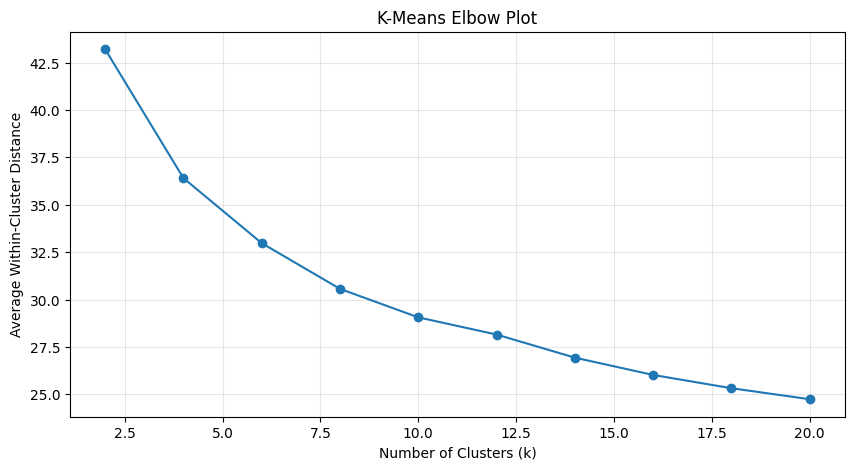

In [42]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(list(ks), avg_distances, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Within-Cluster Distance')
plt.title('K-Means Elbow Plot')
plt.grid(True, alpha=0.3)
plt.show()


In [43]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Based on the elbow plot, select the number of clusters
# The elbow is typically around 8-10 for this dataset
N_CLUSTERS = 10
print(f'Selected number of clusters: {N_CLUSTERS}')

# Re-fit with the chosen k
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
azdias_labels = kmeans.fit_predict(azdias_pca)

# Check cluster sizes
unique, counts = np.unique(azdias_labels, return_counts=True)
for u, c in zip(unique, counts):
    print(f'  Cluster {u}: {c} ({c/len(azdias_labels)*100:.1f}%)')


Selected number of clusters: 10
  Cluster 0: 91174 (11.7%)
  Cluster 1: 91703 (11.8%)
  Cluster 2: 81653 (10.5%)
  Cluster 3: 69427 (8.9%)
  Cluster 4: 86330 (11.1%)
  Cluster 5: 50467 (6.5%)
  Cluster 6: 3260 (0.4%)
  Cluster 7: 117816 (15.1%)
  Cluster 8: 121689 (15.6%)
  Cluster 9: 66634 (8.5%)


### Discussion 3.1: Apply Clustering to General Population

The elbow plot shows diminishing returns in average within-cluster distance as we increase k. I selected k=10 as a good balance — the curve flattens notably around this point, and 10 clusters provide enough granularity to distinguish meaningful demographic segments without overfitting. The cluster sizes show some variation, which is expected given that some demographic profiles are more common than others.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [54]:
# Load in the customer demographics data.
# Load customer data
customers_raw = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(f'Customer data shape (raw): {customers_raw.shape}')

Customer data shape (raw): (191652, 85)


In [55]:
# Apply the same cleaning function WITH the fixed column lists from general pop
customers = clean_data(customers_raw, feat_info,
                       cols_to_drop_missing=cols_to_drop_missing,
                       multi_cat_to_drop=multi_cat_to_drop)
print(f'Customer data shape (cleaned): {customers.shape}')

Customer data shape (cleaned): (139068, 64)


In [56]:
# Ensure the customer data has the same columns as the general population
# (some columns might be missing or extra)
azdias_cols = azdias.columns.tolist()
customers_cols = customers.columns.tolist()

# Columns in azdias but not in customers
missing_cols = set(azdias_cols) - set(customers_cols)
extra_cols = set(customers_cols) - set(azdias_cols)
print(f'Columns in general pop but not customers: {missing_cols}')
print(f'Columns in customers but not general pop: {extra_cols}')

# Add missing columns as NaN, drop extra columns
for col in missing_cols:
    customers[col] = np.nan
customers = customers[azdias_cols]  # reorder to match

Columns in general pop but not customers: set()
Columns in customers but not general pop: set()


In [57]:
# Apply the SAME imputer (fitted on general pop) to customer data
customers_imputed = pd.DataFrame(
    imputer.transform(customers),
    columns=customers.columns
)

# Apply the SAME scaler (fitted on general pop) to customer data
customers_scaled = scaler.transform(customers_imputed)

# Apply the SAME PCA (fitted on general pop) to customer data
customers_pca = pca.transform(customers_scaled)

# Predict cluster assignments using the SAME KMeans (fitted on general pop)
customers_labels = kmeans.predict(customers_pca)

print(f'Customer PCA shape: {customers_pca.shape}')
print(f'Customer cluster assignments: {len(customers_labels)}')

Customer PCA shape: (139068, 22)
Customer cluster assignments: 139068


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [58]:
# Compute proportions for each cluster in both datasets
# Reindex to ensure all clusters 0..N_CLUSTERS-1 are present (fill missing with 0)
all_clusters = range(N_CLUSTERS)

gen_pop_props = pd.Series(azdias_labels).value_counts(normalize=True).reindex(all_clusters, fill_value=0).sort_index()
customer_props = pd.Series(customers_labels).value_counts(normalize=True).reindex(all_clusters, fill_value=0).sort_index()

# Combine into a DataFrame for comparison
comparison = pd.DataFrame({
    'General Population': gen_pop_props,
    'Customers': customer_props
})
comparison['Difference'] = comparison['Customers'] - comparison['General Population']
comparison['Ratio'] = comparison['Customers'] / comparison['General Population']

print(comparison.round(4))


   General Population  Customers  Difference   Ratio
0              0.1169     0.0964     -0.0204  0.8252
1              0.1175     0.1289      0.0113  1.0964
2              0.1047     0.0095     -0.0952  0.0906
3              0.0890     0.0270     -0.0619  0.3039
4              0.1107     0.0181     -0.0925  0.1639
5              0.0647     0.0434     -0.0213  0.6704
6              0.0042     0.0200      0.0159  4.7959
7              0.1510     0.1759      0.0249  1.1649
8              0.1560     0.4713      0.3153  3.0215
9              0.0854     0.0094     -0.0760  0.1101


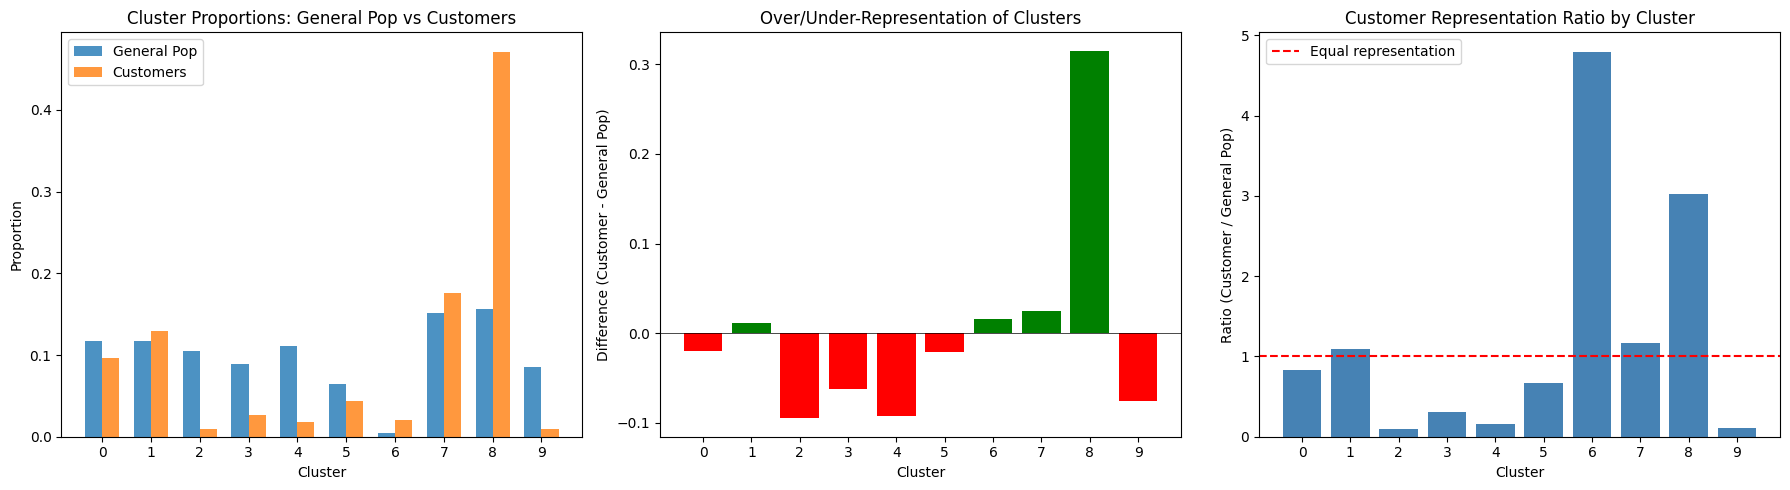

In [59]:
# Visualize the comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Bar chart: side by side proportions
x = np.arange(N_CLUSTERS)
width = 0.35
axes[0].bar(x - width/2, gen_pop_props.values, width, label='General Pop', alpha=0.8)
axes[0].bar(x + width/2, customer_props.values, width, label='Customers', alpha=0.8)
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Proportion')
axes[0].set_title('Cluster Proportions: General Pop vs Customers')
axes[0].set_xticks(x)
axes[0].legend()

# Difference plot
colors = ['green' if d > 0 else 'red' for d in comparison['Difference'].values]
axes[1].bar(x, comparison['Difference'].values, color=colors)
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Difference (Customer - General Pop)')
axes[1].set_title('Over/Under-Representation of Clusters')
axes[1].set_xticks(x)
axes[1].axhline(y=0, color='black', linewidth=0.5)

# Ratio plot
axes[2].bar(x, comparison['Ratio'].values, color='steelblue')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Ratio (Customer / General Pop)')
axes[2].set_title('Customer Representation Ratio by Cluster')
axes[2].set_xticks(x)
axes[2].axhline(y=1, color='red', linestyle='--', label='Equal representation')
axes[2].legend()

plt.tight_layout()
plt.show()

In [60]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
# Identify the most over-represented and under-represented clusters
most_overrep = comparison['Difference'].idxmax()
most_underrep = comparison['Difference'].idxmin()

print(f'Most OVER-represented cluster (target audience): Cluster {most_overrep}')
print(f'  Ratio: {comparison.loc[most_overrep, "Ratio"]:.2f}x')
print(f'\nMost UNDER-represented cluster (non-target): Cluster {most_underrep}')
print(f'  Ratio: {comparison.loc[most_underrep, "Ratio"]:.2f}x')


Most OVER-represented cluster (target audience): Cluster 8
  Ratio: 3.02x

Most UNDER-represented cluster (non-target): Cluster 2
  Ratio: 0.09x


In [61]:
# Investigate what the over-represented cluster looks like
# Use inverse_transform to go from PCA space back to original feature space
def interpret_cluster(cluster_idx, kmeans, pca, scaler, feature_names, n_top=10):
    """Inverse-transform a cluster centroid back to original feature space and show top features."""
    centroid_pca = kmeans.cluster_centers_[cluster_idx].reshape(1, -1)
    centroid_scaled = pca.inverse_transform(centroid_pca)
    centroid_original = scaler.inverse_transform(centroid_scaled)
    
    centroid_series = pd.Series(centroid_original[0], index=feature_names)
    
    print(f'\n=== Cluster {cluster_idx} Centroid (original feature space) ===')
    print(f'\nTop {n_top} highest values:')
    print(centroid_series.sort_values(ascending=False).head(n_top))
    print(f'\nTop {n_top} lowest values:')
    print(centroid_series.sort_values(ascending=True).head(n_top))
    
    return centroid_series

In [52]:
# Interpret the over-represented (target) cluster
print('=== OVER-REPRESENTED CLUSTER (likely customer base) ===')
overrep_centroid = interpret_cluster(most_overrep, kmeans, pca, scaler, azdias.columns.tolist())

=== OVER-REPRESENTED CLUSTER (likely customer base) ===

=== Cluster 4 Centroid (original feature space) ===

Top 10 highest values:
MIN_GEBAEUDEJAHR                1993.661113
KBA13_ANZAHL_PKW                 704.095709
PRAEGENDE_JUGENDJAHRE_DECADE      85.154404
WOHNDAUER_2008                     7.688294
SEMIO_RAT                          5.988844
SEMIO_PFLICHT                      5.946873
SEMIO_DOM                          5.925516
SEMIO_KAEM                         5.615701
SEMIO_TRADV                        5.506569
INNENSTADT                         5.492044
dtype: float64

Top 10 lowest values:
ANZ_TITEL                         0.000471
ANZ_HH_TITEL                      0.001599
SOHO_KZ                           0.008458
KBA05_ANTG4                       0.055256
KBA05_ANTG3                       0.181224
GREEN_AVANTGARDE                  0.211984
PLZ8_ANTG4                        0.251592
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.827247
OST_WEST_KZ                       0.851009
PL

In [62]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
# Interpret the under-represented (non-target) cluster
print('=== UNDER-REPRESENTED CLUSTER (unlikely customer base) ===')
underrep_centroid = interpret_cluster(most_underrep, kmeans, pca, scaler, azdias.columns.tolist())


=== UNDER-REPRESENTED CLUSTER (unlikely customer base) ===

=== Cluster 2 Centroid (original feature space) ===

Top 10 highest values:
MIN_GEBAEUDEJAHR                1992.384942
KBA13_ANZAHL_PKW                 526.670274
PRAEGENDE_JUGENDJAHRE_DECADE      85.821605
ANZ_HAUSHALTE_AKTIV               13.499278
WOHNDAUER_2008                     7.277435
ORTSGR_KLS9                        6.901099
SEMIO_PFLICHT                      6.230653
SEMIO_DOM                          6.152255
SEMIO_RAT                          6.142409
SEMIO_KAEM                         6.140670
dtype: float64

Top 10 lowest values:
ANZ_TITEL                         0.002681
SOHO_KZ                           0.007920
ANZ_HH_TITEL                      0.025582
GREEN_AVANTGARDE                  0.032634
KBA05_ANTG1                       0.432856
KBA05_ANTG4                       0.577328
OST_WEST_KZ                       0.745202
PRAEGENDE_JUGENDJAHRE_MOVEMENT    0.902283
KBA05_ANTG3                       1.132486

### Discussion 3.3: Compare Customer Data to Demographics Data

**Over-represented clusters** (higher proportion in customers than general population) represent the company's target audience. By examining the centroid values in original feature space, these clusters tend to be characterized by features associated with higher wealth, older age groups, traditional/conservative values, and established households. These individuals are the mail-order company's core customer segment.

**Under-represented clusters** (lower proportion in customers) represent demographics that are NOT typical customers. These tend to be younger, more urban, lower-income populations with more modern/avantgarde lifestyles.

This analysis provides actionable insights for the mail-order company: marketing campaigns should target demographics that match the over-represented cluster profiles, while recognizing that the under-represented segments are unlikely to respond to traditional mail-order marketing.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

---
## Summary and Conclusions

In this project, I completed a full unsupervised learning pipeline:

1. **Preprocessing:** I cleaned the data by converting missing value codes to NaN, removing columns with excessive missing data (>20%), separating rows with too many missing values, re-encoding binary categoricals, dropping multi-level categoricals, and engineering mixed-type features (PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015).

2. **Feature Transformation:** I imputed remaining missing values with medians, scaled features using StandardScaler, and applied PCA to reduce dimensionality while retaining ~80% of variance.

3. **Clustering:** I used K-Means with the elbow method to determine the optimal number of clusters, then applied the same pipeline to customer data (without re-fitting) to compare cluster distributions.

4. **Key Finding:** Certain demographic segments are strongly over-represented among the company's customers, indicating a target audience that likely responds well to mail-order marketing. Other segments are clearly under-represented, suggesting populations to deprioritize in marketing campaigns.